In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xarray as xr

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Open BARRA data

In [3]:
def open_files(variable,lat_start,lat_end,lon_start,lon_end):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"
            ] #"202203-202203","202204-202204": removed as not in radar domain; barra goes back to 2007 (radar till 08-2011)
    fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable+"/"
    data = []
    for months in list:
        # to get specific hour, edit: u.ua850.isel(time=(barra2_202201.time.dt.hour == hour)
        var = xr.open_dataset(fp+variable+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+months+".nc", engine="h5netcdf",chunks="auto")#{'time':-1})
        mean = var[variable].sel(lat=slice(lat_start,lat_end),lon=slice(lon_start,lon_end))
        var_mean = mean.mean(dim=["lat","lon"])    
        data.append(var_mean)
    return data 

In [4]:
%%time
# wind_mean_u = open_files("ua850",-20.768799,-18.0708,145.12054,147.9812) #townsville
# wind_mean_v = open_files("va850",-20.768799,-18.0708,145.12054,147.9812) #townsville

wind_mean_u = open_files("ua850",-18.165955,-15.468018,144.27374,147.09222) #cairns
wind_mean_v = open_files("va850",-18.165955,-15.468018,144.27374,147.09222) #cairns

# wind_mean_u = open_files("ua850",-17.636353,-14.938416,148.55927,151.36993) #willis island
# wind_mean_v = open_files("va850",-17.636353,-14.938416,148.55927,151.36993) #willis island

CPU times: user 7.65 s, sys: 3.07 s, total: 10.7 s
Wall time: 26 s


In [5]:
%%time
concat_u = xr.concat(wind_mean_u,"time")
concat_v = xr.concat(wind_mean_v,"time")
uu = (concat_u * units("m/s")).compute()
vv = (concat_v * units("m/s")).compute()

KeyboardInterrupt: 

In [6]:
%%time
wind_dir = metpy.calc.wind_direction(uu, vv, convention='from')
wind_speed = metpy.calc.wind_speed(uu, vv)

NameError: name 'uu' is not defined

In [7]:
%%time
wind_dir.persist()
wind_speed.persist()

NameError: name 'wind_dir' is not defined

# Plot windrose from BARRA2

In [ ]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm

orig_map = plt.cm.get_cmap('cool')
rev_map = orig_map.reversed()
ax = WindroseAxes.from_ax(figsize=(6,15))
# ax.bar(direction, speed, opening=0.8, edgecolor='white', cmap=orig_map)
ax.bar(wind_dir, wind_speed, opening=0.8, edgecolor='white', cmap=orig_map)
ax.set_title("Townsville Mean 850hPa Wind Rose JFMA 2012-2022",fontsize=20)
ax.set_legend();

# Open radar data

In [7]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
            "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
            "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
           ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="netcdf4")

In [29]:
# open radar ds
#ds_radar_T = open_radar_ds("73")
ds_radar_C = open_radar_ds("19")
# ds_radar_W = open_radar_ds("41")

# Open bathymetry dataset

In [9]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")

In [10]:
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

In [11]:
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)

# Define function for plotting and masking

In [23]:
def plot_mean_rr(ds_radar,wind_dir1,wind_dir2,threshold,mask_threshold,annx,anny,lon1,lon2,lat1,lat2,xticks,xticklabels,yticks,yticklabels,cmapcb,cmap,vmax,title):
    radar_mean = ds_radar.rainrate.isel(x=slice(0,300),y=slice(0,300)).mean(dim="time")
    # create masked data by threshold set at 1.5mm/h
    masked_ds = xr.where((radar_mean < threshold), np.nan, radar_mean)
 ########
    # calc winds
    winds = wind_dir[(wind_dir>wind_dir1*units("degree"))&(wind_dir<wind_dir2*units("degree"))]
    # select wind time values
    wind_times = winds.time.values
    wind_times.sort() 

    # select radar data times which closest equal to easterly times
    mean_rr = ds_radar.isel(x=slice(0,300),y=slice(0,300)).rainrate.sel(time=wind_times,method="nearest").mean(dim=["time"]) 

    # mask data
    masked_data = xr.where((radar_mean < threshold), np.nan,mean_rr)
    # masked_data = xr.where(((threshold1 < rr_mean)&(rr_mean < threshold2)), rr_mean, np.nan)

    # plot
    fig = plt.figure(1, figsize=[10,6])
    fig.patch.set_facecolor('white')
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    # ax.coastlines()

    sel_lat_lon = ds_bath["z"].sel(x=slice(lon1,lon2),y=slice(lat1,lat2))
    cmapc = plt.get_cmap(cmapcb)
    sel_lat_lon.plot.contour(levels=7,ax=ax, cmap=cmapc,alpha=1,vmin=0)
    ax.annotate(mask_threshold,(annx,anny),fontsize=10)
    ax.set_xlim(lon1,lon2) 
    ax.set_ylim(lat1,lat2)  
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Longitude")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Latitude")
    ax.set_title(title,fontsize=15)

    # plotting mean rain rate for each x, y across all easterly times
    norm = mcolors.Normalize(vmin=0, vmax=vmax)  # Normalize the cb data
    cmapcf = plt.get_cmap(cmap)
    cf = ax.contourf(ds_radar.longitude.isel(time=0,x=slice(0,294),y=slice(0,294)),ds_radar.latitude.isel(time=0,x=slice(0,294),y=slice(0,294)),
                     masked_data.isel(x=slice(0,294),y=slice(0,294)),levels=50,vmin=0,vmax=vmax,cmap=cmapcf,alpha=1,norm=norm)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmapcf))
    cb.set_label('Rain rate (mm/h)')
    plt.tight_layout()
    return

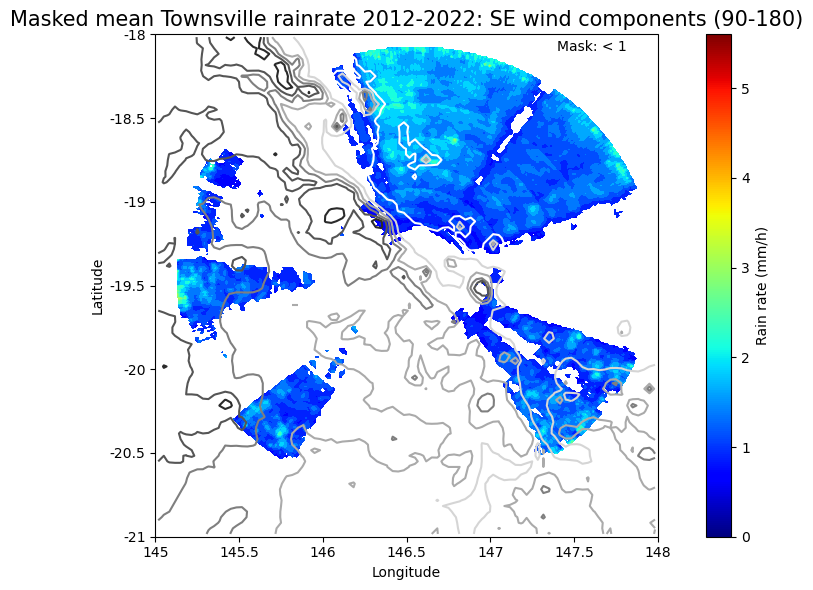

In [22]:
# Townsville

# westerlies
# plot_mean_rr(ds_radar_T,180,360,1,"Mask: < 1",147.4,-18.1,145,148,-21,-18,[145,145.5,146,146.5,147,147.5,148],["145","145.5","146","146.5","147","147.5","148"],
#             [-21,-20.5,-20,-19.5,-19,-18.5,-18],["-21","-20.5","-20","-19.5","-19","-18.5","-18"],"binary","jet",5.6,
#             "Masked mean Townsville rainrate 2012-2022: Westerly wind components")
# NEs
# plot_mean_rr(ds_radar_T,0,90,1,"Mask: < 1",147.4,-18.1,145,148,-21,-18,[145,145.5,146,146.5,147,147.5,148],["145","145.5","146","146.5","147","147.5","148"],
#             [-21,-20.5,-20,-19.5,-19,-18.5,-18],["-21","-20.5","-20","-19.5","-19","-18.5","-18"],"binary","jet",5.6,
#             "Masked mean Townsville rainrate 2012-2022: NE wind components (0-90)")
# SEs
# plot_mean_rr(ds_radar_T,90,180,1,"Mask: < 1",147.4,-18.1,145,148,-21,-18,[145,145.5,146,146.5,147,147.5,148],["145","145.5","146","146.5","147","147.5","148"],
#              [-21,-20.5,-20,-19.5,-19,-18.5,-18],["-21","-20.5","-20","-19.5","-19","-18.5","-18"],"binary","jet",5.6,
#              "Masked mean Townsville rainrate 2012-2022: SE wind components (90-180)")

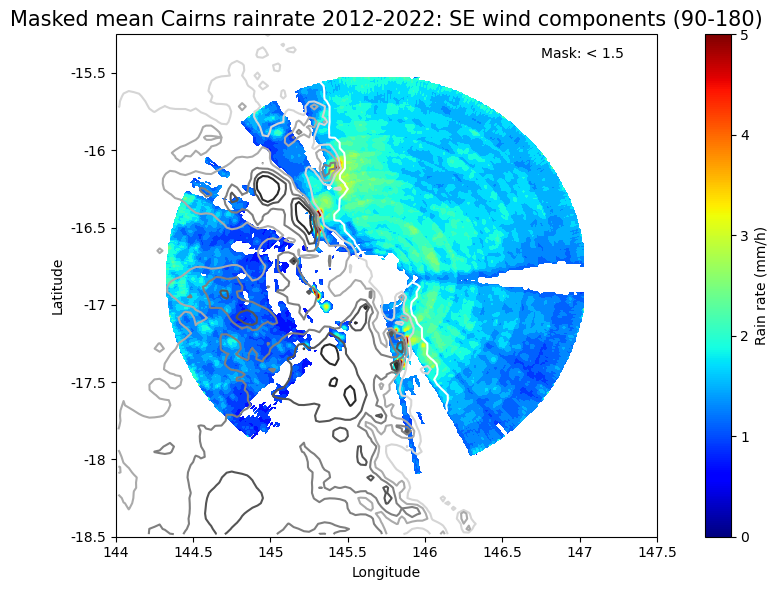

In [24]:
# Cairns: (ds_radar,wind_dir1,wind_dir2,threshold1,threshold2,mask_threshold,annx,anny,lon1,lon2,lat1,lat2,xticks,xticklabels,yticks,yticklabels,cmapcb,cmap,vmax,title)

# westerlies
# plot_mean_rr(ds_radar_C,180,360,1.5,"Mask: < 1.5",146.5,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],
#             ["144","144.5","145","145.5","146","146.5","147","147.5"],[-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#             ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: Westerly wind components")
# NEs     
# plot_mean_rr(ds_radar_C,0,90,1.5,"Mask: < 1.5",146.5,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],["144","144.5","145","145.5","146","146.5","147","147.5"],
#             [-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#             ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: NE wind components (0-90)")
# SEs
# plot_mean_rr(ds_radar_C,90,180,1.5,"Mask: < 1.5",146.75,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],["144","144.5","145","145.5","146","146.5","147","147.5"],
#              [-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#              ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: SE wind components (90-180)") 
            # .isel(x=slice(0,294),y=slice(0,294)): for SE there is a weird piece in the data, this means it won't be plotted

# Diurnal precip

In [ ]:
# using magnitude (convert to degrees), select only data between 180-360 degrees
wind = wind_dir[180*units("degree")<wind_dir]
# select westerly time values
wind_times = wind.time.values
wind_times.sort() # sort so index is more similar to radar time index

# select radar data times which closest equal to westerly times 
ds_W_wind = ds_radar_T.sel(time=wind_times,method="nearest")
rr_mean = ds_W_wind.rainrate.mean(dim=["time"])

# mask wind_dir (threshold differs based on direction and location) 
masked_data = xr.where(rr_mean < 1, rr_mean, np.nan)

In [ ]:
hour_comp = ds_W_wind.groupby(ds_W_wind.time.dt.hour)   # used ds_W_wind rather than masked_data as masked_data doesn't have a time coordinate
diurnal_rr = []
for hours in np.arange(0,24,1):
    # hour_comp_mean = hour_comp[hours].rainrate.mean(dim=["x","y"],skipna=True)
    # masked_data = xr.where(hour_comp_mean < 1, hour_comp_mean, np.nan) 
    rr_mean = hour_comp[hours].rainrate.mean(dim=["x","y","time"],skipna=True)
    diurnal_rr.append(rr_mean)hour_comp = ds_W_wind.groupby(ds_W_wind.time.dt.hour)   # used ds_W_wind rather than masked_data as masked_data doesn't have a time coordinate
diurnal_rr = []
for hours in np.arange(0,24,1):
    # hour_comp_mean = hour_comp[hours].rainrate.mean(dim=["x","y"],skipna=True)
    # masked_data = xr.where(hour_comp_mean < 1, hour_comp_mean, np.nan) 
    rr_mean = hour_comp[hours].rainrate.mean(dim=["x","y","time"],skipna=True)
    diurnal_rr.append(rr_mean)

In [ ]:
plt.plot(diurnal_rr,np.arange(0,24,1))

# Plot for Willis island

In [39]:
# using magnitude (convert to degrees), select only data between 180-360 degrees
wind = wind_dir[(wind_dir>0*units("degree"))&(wind_dir<90*units("degree"))]
# select westerly time values
wind_times = wind.time.values
wind_times.sort() # sort so index is more similar to radar time index

# select radar data times which closest equal to westerly times 
ds_W_wind = ds_radar_W.sel(time=wind_times,method="nearest")
rr_mean = ds_W_wind.rainrate.mean(dim=["time"])

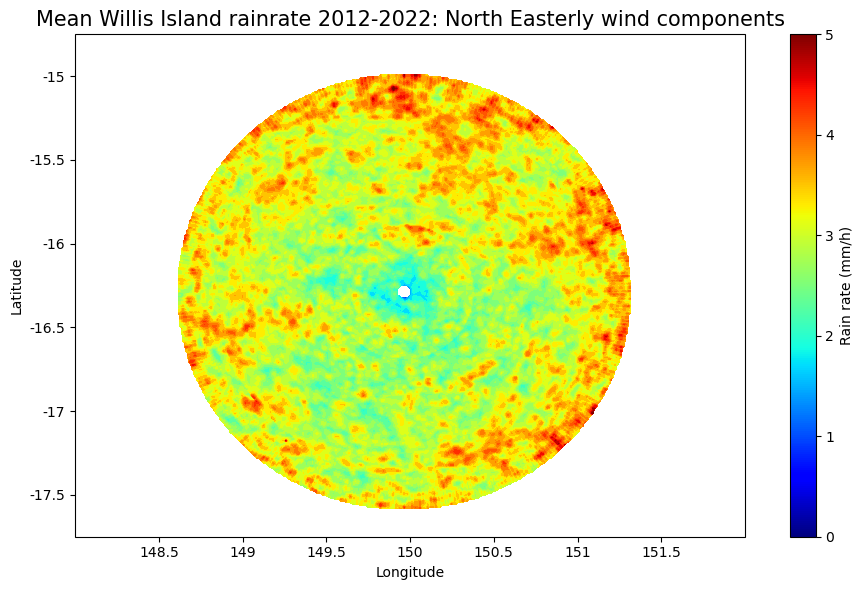

In [40]:
# plot
# %%time
fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_xlim(148,152) 
ax.set_ylim(-17.75,-14.75) 
ax.set_xticks([148.5,149,149.5,150,150.5,151,151.5])
ax.set_xticklabels(["148.5","149","149.5","150","150.5","151","151.5"])
ax.set_xlabel("Longitude")
ax.set_yticks([-17.5,-17,-16.5,-16,-15.5,-15])
ax.set_yticklabels(["-17.5","-17","-16.5","-16","-15.5","-15"])
ax.set_ylabel("Latitude")
ax.set_title("Mean Willis Island rainrate 2012-2022: North Easterly wind components",fontsize=15)

# plotting mean rain rate for each x, y across all westerly times
cmap = plt.get_cmap('jet')
norm = mcolors.Normalize(vmin=0, vmax=5)  # Normalize the data
cf = ax.contourf(ds_radar_W.longitude.isel(time=0),ds_radar_W.latitude.isel(time=0),rr_mean,
                 cmap=cmap,alpha=1,vmin=0,vmax=5,norm=norm,levels=25)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cb.set_label('Rain rate (mm/h)')
plt.tight_layout()

In [ ]:
#info
winds = wind_dir[(wind_dir>180*units("degree"))&(wind_dir<360*units("degree"))]
wind_times = winds.time.values
len(wind_times)

# Precip roses

In [ ]:
# using magnitude (convert to degrees), select data between 180-360 degrees, 
easterlies1 = wind_dir[(wind_dir>=0*units("degree"))&(wind_dir<30*units("degree"))]
easterlies2 = wind_dir[(wind_dir>=30*units("degree"))&(wind_dir<60*units("degree"))]
easterlies3 = wind_dir[(wind_dir>=60*units("degree"))&(wind_dir<90*units("degree"))]
easterlies4 = wind_dir[(wind_dir>=90*units("degree"))&(wind_dir<120*units("degree"))]
easterlies5 = wind_dir[(wind_dir>=120*units("degree"))&(wind_dir<150*units("degree"))]
easterlies6 = wind_dir[(wind_dir>=150*units("degree"))&(wind_dir<180*units("degree"))]
westerlies1 = wind_dir[(wind_dir>=180*units("degree"))&(wind_dir<210*units("degree"))]
westerlies2 = wind_dir[(wind_dir>=210*units("degree"))&(wind_dir<240*units("degree"))]
westerlies3 = wind_dir[(wind_dir>=240*units("degree"))&(wind_dir<270*units("degree"))]
westerlies4 = wind_dir[(wind_dir>=270*units("degree"))&(wind_dir<300*units("degree"))]
westerlies5 = wind_dir[(wind_dir>=300*units("degree"))&(wind_dir<330*units("degree"))]
westerlies6 = wind_dir[330*units("degree")<wind_dir]
# select time values
eaterly_times1 = easterlies1.time.values
eaterly_times2 = easterlies2.time.values
eaterly_times3 = easterlies3.time.values
eaterly_times4 = easterlies4.time.values
eaterly_times5 = easterlies5.time.values
eaterly_times6 = easterlies6.time.values
westerly_times1 = westerlies1.time.values
westerly_times2 = westerlies2.time.values
westerly_times3 = westerlies3.time.values
westerly_times4 = westerlies4.time.values
westerly_times5 = westerlies5.time.values
westerly_times6 = westerlies6.time.values

# sort so index is more similar to radar time index
eaterly_times1.sort()
eaterly_times2.sort()
eaterly_times3.sort()
eaterly_times4.sort()
eaterly_times5.sort()
eaterly_times6.sort()
westerly_times1.sort() 
westerly_times2.sort() 
westerly_times3.sort() 
westerly_times4.sort() 
westerly_times5.sort() 
westerly_times6.sort() 

In [ ]:
# select radar data times which closest equal to westerly times
ds_T_easterlies1 = ds_radar_T.sel(time=eaterly_times1,method="nearest") 
ds_T_easterlies2 = ds_radar_T.sel(time=eaterly_times2,method="nearest") 
ds_T_easterlies3 = ds_radar_T.sel(time=eaterly_times3,method="nearest") 
ds_T_easterlies4 = ds_radar_T.sel(time=eaterly_times4,method="nearest") 
ds_T_easterlies5 = ds_radar_T.sel(time=eaterly_times5,method="nearest") 
ds_T_easterlies6 = ds_radar_T.sel(time=eaterly_times6,method="nearest") 
ds_T_westerlies1 = ds_radar_T.sel(time=westerly_times1,method="nearest")
ds_T_westerlies2 = ds_radar_T.sel(time=westerly_times2,method="nearest")
ds_T_westerlies3 = ds_radar_T.sel(time=westerly_times3,method="nearest")
ds_T_westerlies4 = ds_radar_T.sel(time=westerly_times4,method="nearest")
ds_T_westerlies5 = ds_radar_T.sel(time=westerly_times5,method="nearest")
ds_T_westerlies6 = ds_radar_T.sel(time=westerly_times6,method="nearest")

# find mean rr's
rr_mean0_30 = ds_T_easterlies1.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean30_60 = ds_T_easterlies2.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean60_90 = ds_T_easterlies3.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean90_120 = ds_T_easterlies4.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean120_150 = ds_T_easterlies5.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean150_180 = ds_T_easterlies6.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean180_210 = ds_T_westerlies1.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean210_240 = ds_T_westerlies2.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean240_270 = ds_T_westerlies3.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean270_300 = ds_T_westerlies4.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean300_330 = ds_T_westerlies5.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean330_360 = ds_T_westerlies6.rainrate.mean(dim=["x","y"],skipna=True) #mean across x, y plane

# new array
E_values1 = []
E_values2 = []
E_values3 = []
E_values4 = []
E_values5 = []
E_values6 = []
W_values1 = []
W_values2 = []
W_values3 = []
W_values4 = []
W_values5 = []
W_values6 = []
E_values1.extend(rr_mean0_30.values)
E_values2.extend(rr_mean30_60.values)
E_values3.extend(rr_mean60_90.values)
E_values4.extend(rr_mean90_120.values)
E_values5.extend(rr_mean120_150.values)
E_values6.extend(rr_mean150_180.values)
W_values1.extend(rr_mean180_210.values)
W_values2.extend(rr_mean210_240.values)
W_values3.extend(rr_mean240_270.values)
W_values4.extend(rr_mean270_300.values)
W_values5.extend(rr_mean300_330.values)
W_values6.extend(rr_mean330_360.values)

In [ ]:
# get westerly values
def categorise_rr(wind_dir_rr_values):
    group1W = [num for num in wind_dir_rr_values if 0.0 < num <= 0.5]
    group2W = [num for num in wind_dir_rr_values if 0.5 < num <= 1]
    group3W = [num for num in wind_dir_rr_values if 1 < num <= 2]
    group4W = [num for num in wind_dir_rr_values if 2 < num <= 4]
    group5W = [num for num in wind_dir_rr_values if 4 < num <= 8]
    group6W = [num for num in wind_dir_rr_values if num > 8]
    return [group1W,group2W,group3W,group4W,group5W,group6W]
rr_E1 = categorise_rr(E_values1)
rr_E2 = categorise_rr(E_values2)
rr_E3 = categorise_rr(E_values3)
rr_E4 = categorise_rr(E_values4)
rr_E5 = categorise_rr(E_values5)
rr_E6 = categorise_rr(E_values6)
rr_W1 = categorise_rr(W_values1)
rr_W2 = categorise_rr(W_values2)
rr_W3 = categorise_rr(W_values3)
rr_W4 = categorise_rr(W_values4)
rr_W5 = categorise_rr(W_values5)
rr_W6 = categorise_rr(W_values6)

In [ ]:
# create array with counts for each rr category and each direction info
counts = [
    [len(rr_E1[0]),len(rr_E2[0]),len(rr_E3[0]),len(rr_E4[0]),len(rr_E5[0]),len(rr_E6[0]),len(rr_W1[0]),len(rr_W2[0]),len(rr_W3[0]),len(rr_W4[0]),len(rr_W5[0]),len(rr_W6[0])],    
    [len(rr_E1[1]),len(rr_E2[1]),len(rr_E3[1]),len(rr_E4[1]),len(rr_E5[1]),len(rr_E6[1]),len(rr_W1[1]),len(rr_W2[1]),len(rr_W3[1]),len(rr_W4[1]),len(rr_W5[1]),len(rr_W6[1])],
    [len(rr_E1[2]),len(rr_E2[2]),len(rr_E3[2]),len(rr_E4[2]),len(rr_E5[2]),len(rr_E6[2]),len(rr_W1[2]),len(rr_W2[2]),len(rr_W3[2]),len(rr_W4[2]),len(rr_W5[2]),len(rr_W6[2])],
    [len(rr_E1[3]),len(rr_E2[3]),len(rr_E3[3]),len(rr_E4[3]),len(rr_E5[3]),len(rr_E6[3]),len(rr_W1[3]),len(rr_W2[3]),len(rr_W3[3]),len(rr_W4[3]),len(rr_W5[3]),len(rr_W6[3])],
    [len(rr_E1[4]),len(rr_E2[4]),len(rr_E3[4]),len(rr_E4[4]),len(rr_E5[4]),len(rr_E6[4]),len(rr_W1[4]),len(rr_W2[4]),len(rr_W3[4]),len(rr_W4[4]),len(rr_W5[4]),len(rr_W6[4])],
    [len(rr_E1[5]),len(rr_E2[5]),len(rr_E3[5]),len(rr_E4[5]),len(rr_E5[5]),len(rr_E6[5]),len(rr_W1[5]),len(rr_W2[5]),len(rr_W3[5]),len(rr_W4[5]),len(rr_W5[5]),len(rr_W6[5])]
]
# westerlies only
#counts = [
#    [len(rr_W1[0]),len(rr_W2[0]),len(rr_W3[0]),len(rr_W4[0]),len(rr_W5[0]),len(rr_W6[0])],    
#    [len(rr_W1[1]),len(rr_W2[1]),len(rr_W3[1]),len(rr_W4[1]),len(rr_W5[1]),len(rr_W6[1])],
#    [len(rr_W1[2]),len(rr_W2[2]),len(rr_W3[2]),len(rr_W4[2]),len(rr_W5[2]),len(rr_W6[2])],
#    [len(rr_W1[3]),len(rr_W2[3]),len(rr_W3[3]),len(rr_W4[3]),len(rr_W5[3]),len(rr_W6[3])],
#    [len(rr_W1[4]),len(rr_W2[4]),len(rr_W3[4]),len(rr_W4[4]),len(rr_W5[4]),len(rr_W6[4])],
#   [len(rr_W1[5]),len(rr_W2[5]),len(rr_W3[5]),len(rr_W4[5]),len(rr_W5[5]),len(rr_W6[5])]
#]

In [ ]:
# define stacked bar polar plot
def stacked_bar_polar_plot(data,rr_category,rr_values):
    num_categories = len(rr_category)
    num_samples = len(data)

    # create plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111,polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # pie slices
    angles = [0.0,(1/6)*np.pi,(2/6)*np.pi,(3/6)*np.pi,(4/6)*np.pi,(5/6)*np.pi,1*np.pi,(7/6)*np.pi,(8/6)*np.pi,(9/6)*np.pi,(10/6)*np.pi,(11/6)*np.pi]
    #angles = [1*np.pi,(7/6)*np.pi,(8/6)*np.pi,(9/6)*np.pi,(10/6)*np.pi,(11/6)*np.pi]
    width = [0.52]
    
    # stack bars
    bottom = np.zeros(12)
    colors = plt.cm.get_cmap("jet",num_categories)
    for i in range(num_samples):
        ax.bar(angles,data[i],width=width,bottom=bottom,alpha=0.7,color=colors(i),align="edge")
        bottom +=data[i]
    
    # set group labels
    custom_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW','W','NW']
    theta = [0.0,(1/4) * np.pi,(2/4) * np.pi,(3/4) * np.pi,(4/4) * np.pi,(5/4) * np.pi,(6/4) * np.pi,(7/4) * np.pi]
    ax.set_xticks(theta)
    ax.set_xticklabels(custom_labels)
    
    # set title
    ax.set_title("Precipitation Rose - Townsville")

    # set legend
    ax.legend(title="Precipitation (mm/h)",labels=[rr_values[0],rr_values[1],rr_values[2],rr_values[3],rr_values[4],rr_values[5]],loc="lower left")
    plt.show()
rr_values = ["0<RR<=0.5","0.5 - 1","1 - 2","2 - 4","4 - 8","> 8"]
stacked_bar_polar_plot(counts,rr_values,rr_values)


In [ ]:
bins = [0,0.5,1,2,4,8,16]

# create subplots
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
counts_bar = [
    # [len(rr_E1[0]),len(rr_E1[1]),len(rr_E1[2]),len(rr_E1[3]),len(rr_E1[4]),len(rr_E1[5])],
    # [len(rr_E2[0]),len(rr_E2[1]),len(rr_E2[2]),len(rr_E2[3]),len(rr_E2[4]),len(rr_E2[5])],
    # [len(rr_E3[0]),len(rr_E3[1]),len(rr_E3[2]),len(rr_E3[3]),len(rr_E3[4]),len(rr_E3[5])],
    # [len(rr_E4[0]),len(rr_E4[1]),len(rr_E4[2]),len(rr_E4[3]),len(rr_E4[4]),len(rr_E4[5])],
    # [len(rr_E5[0]),len(rr_E5[1]),len(rr_E5[2]),len(rr_E5[3]),len(rr_E5[4]),len(rr_E5[5])],
    # [len(rr_E6[0]),len(rr_E6[1]),len(rr_E6[2]),len(rr_E6[3]),len(rr_E6[4]),len(rr_E6[5])],
   [len(rr_W1[0]),len(rr_W1[1]),len(rr_W1[2]),len(rr_W1[3]),len(rr_W1[4]),len(rr_W1[5])],
   [len(rr_W2[0]),len(rr_W2[1]),len(rr_W2[2]),len(rr_W2[3]),len(rr_W2[4]),len(rr_W2[5])],
   [len(rr_W3[0]),len(rr_W3[1]),len(rr_W3[2]),len(rr_W3[3]),len(rr_W3[4]),len(rr_W3[5])],
   [len(rr_W4[0]),len(rr_W4[1]),len(rr_W4[2]),len(rr_W4[3]),len(rr_W4[4]),len(rr_W4[5])],
   [len(rr_W5[0]),len(rr_W5[1]),len(rr_W5[2]),len(rr_W5[3]),len(rr_W5[4]),len(rr_W5[5])],
   [len(rr_W6[0]),len(rr_W6[1]),len(rr_W6[2]),len(rr_W6[3]),len(rr_W6[4]),len(rr_W6[5])]
]
rr_cat_length = np.arange(0,6,1)
bar_width = 1
colors = ['blue', 'aqua', 'lime', 'yellow', 'red',"purple"]
ax[0,0].bar(rr_cat_length,counts_bar[0], color=colors, width=bar_width, align='center')
ax[0,1].bar(rr_cat_length,counts_bar[1], color=colors, width=bar_width, align='center')
ax[0,2].bar(rr_cat_length,counts_bar[2], color=colors, width=bar_width, align='center')
ax[1,0].bar(rr_cat_length,counts_bar[3], color=colors, width=bar_width, align='center')
ax[1,1].bar(rr_cat_length,counts_bar[4], color=colors, width=bar_width, align='center')
ax[1,2].bar(rr_cat_length,counts_bar[5], color=colors, width=bar_width, align='center')

# x ticks and xtick labels
rr_values = ["0-0.5","0.5-1","1-2","2-4","4-8","8-16"]
ax[0,0].set_xticks(rr_cat_length)
ax[0,0].set_xticklabels(rr_values)
ax[0,0].set_xlabel("Rain rate (mm/h)")
ax[0,1].set_xticks(rr_cat_length)
ax[0,1].set_xticklabels(rr_values)
ax[0,1].set_xlabel("Rain rate (mm/h)")
ax[0,2].set_xticks(rr_cat_length)
ax[0,2].set_xticklabels(rr_values)
ax[0,2].set_xlabel("Rain rate (mm/h)")
ax[1,0].set_xticks(rr_cat_length)
ax[1,0].set_xticklabels(rr_values)
ax[1,0].set_xlabel("Rain rate (mm/h)")
ax[1,1].set_xticks(rr_cat_length)
ax[1,1].set_xticklabels(rr_values)
ax[1,1].set_xlabel("Rain rate (mm/h)")
ax[1,2].set_xticks(rr_cat_length)
ax[1,2].set_xticklabels(rr_values)
ax[1,2].set_xlabel("Rain rate (mm/h)")
# set y labels
ax[0,0].set_ylabel("Counts")
ax[1,0].set_ylabel("Counts")
ax[0,0].set_ylim(0,500)
ax[0,1].set_ylim(0,500)
ax[0,2].set_ylim(0,500)
ax[1,0].set_ylim(0,500)
ax[1,1].set_ylim(0,500)
ax[1,2].set_ylim(0,500)

# set plot labels
fig.suptitle("Rain rate counts by intensity for westerly wind directions - Townsville")
ax[0,0].set_title("180-210")  #"0-30") #
ax[0,1].set_title("210-240") #"30-60")# 
ax[0,2].set_title("240-270") #"60-90") #
ax[1,0].set_title("270-300") #"90-120")#
ax[1,1].set_title("300-330") #""120-150")#
ax[1,2].set_title("330-360") #"150-180")#

plt.tight_layout()